## pips and includes

In [1]:
import pandas as pd
import requests
import json
from datetime import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Constants

In [2]:
BEGINING_OF_YEAR = "01010000"
ENDING_OF_YEAR = "12312350"
START_YEAR = 2005
END_YEAR = 2024

DATA_DIRECTORY = "../data/newFinalStations/"

columns = [
    "Date Time", "BP (hPa)", "DiffR (w/m^2)", "Grad (w/m^2)", "NIP (w/m^2)", "RH (%)",
    "TD (degC)", "TDmax (degC)", "TDmin (degC)", "WD (deg)", "WDmax (deg)",
    "WS (m/s)", "Ws1mm (m/s)", "Ws10mm (m/s)", "WSmax (m/s)", "STDwd (deg)"
]

column_pairs = [
    ("date", "Date Time"),
    ("BP", "BP (hPa)"),
    ("DiffR", "DiffR (w/m^2)"),
    ("Grad", "Grad (w/m^2)"),
    ("NIP", "NIP (w/m^2)"),
    ("RH", "RH (%)"),
    ("TD", "TD (degC)"),
    ("TDmax", "TDmax (degC)"),
    ("TDmin", "TDmin (degC)"),
    ("WD", "WD (deg)"),
    ("WDmax", "WDmax (deg)"),
    ("WS", "WS (m/s)"),
    ("WS1mm", "Ws1mm (m/s)"),
    ("Ws10mm", "Ws10mm (m/s)"),
    ("WSmax", "WSmax (m/s)"),
    ("STDwd", "STDwd (deg)")
]

na_values = ['None', 'null', '-', '', ' ', 'NaN', 'nan', 'NAN']

### the stations:

In [3]:
newStationsLst = {
    "Newe Yaar": "186",
    "Tavor Kadoorie": "13",
    "Yavneel": "11"
}

# Importing New Data

## Utills functions

### processing:

In [40]:
def remove_unwanted_keys(data):
    # Remove 'sid', 'sname', and 'date_for_sort' from each record in data
    for record in data['data']['records']:
        # if 'date_for_sort' in record:
        #     del record['date_for_sort']
        if 'sid' in record:
            del record['sid']
        if 'TW' in record:
            del record['TW']
        if 'sname' in record:
            del record['sname']

def replace_column_names(data):
    # Replace the names of the columns by the pairs in column_pairs
    for record in data['data']['records']:
        for new_name, old_name in column_pairs:
            if new_name in record:
                record[old_name] = record.pop(new_name)

def process_data(data):
    remove_unwanted_keys(data)
    replace_column_names(data)

def save_to_csv(data, filename):
    import csv
    # Extract the column names from the first record
    column_names = data['data']['records'][0].keys()
    # Open the file in write mode
    with open(DATA_DIRECTORY+filename, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=column_names)
        # Write the header
        writer.writeheader()
        # Write the data
        for record in data['data']['records']:
            writer.writerow(record)

### fetching:

In [41]:
def fetch_weather_data(station_id, start_date, end_date):
    url = f"https://ims.gov.il/he/envista_station_all_data_time_range/{station_id}/BP%26DiffR%26Grad%26NIP%26RH%26TD%26TDmax%26TDmin%26TW%26WD%26WDmax%26WS%26WS1mm%26Ws10mm%26Ws10maxEnd%26WSmax%26STDwd%26Rain/{start_date}/{end_date}/1/S"
    response = requests.get(url)
    data = json.loads(response.content)
    return data


def fetch_data_for_station(station_id, start_year, end_year):
    all_data = []
    for year in range(start_year, end_year + 1):
        today_fore0 = f"{year}" + BEGINING_OF_YEAR
        today_fore23 = f"{year}" + ENDING_OF_YEAR
        data = fetch_weather_data(station_id, today_fore0, today_fore23)
        process_data(data)
        # Convert the data to a DataFrame and append to the list
        df = pd.DataFrame(data['data']['records'])
        all_data.append(df)
    # Concatenate all DataFrames
    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df


def get_and_save_station_data(station_name, station_id, start_year, end_year):
    # Get all data for the station
    combined_df = fetch_data_for_station(station_id, start_year, end_year)
    # Convert the DataFrame back to the dictionary format expected by process_data
    data = {'data': {'records': combined_df.to_dict(orient='records')}}
    # Process the data
    process_data(data)
    # Save the data to a CSV file
    filename = f"{station_name}_data_{start_year}_{end_year}.csv"
    save_to_csv(data, filename)



## Download from IMS

### download data:

In [42]:
# for station_name, station_id in newStationsLst.items():
#     filename = f"{DATA_DIRECTORY}{station_name}_data_{START_YEAR}_{END_YEAR}.csv"
#     if not os.path.exists(filename):
#         print(f"Downloading data for {station_name}")
#         try:
#             get_and_save_station_data(station_name, station_id, START_YEAR, END_YEAR)
#         except IndexError as e:
#             print(f"Error processing data for {station_name}: {e}")

# Sync files

In [22]:
data_files = [f for f in os.listdir(DATA_DIRECTORY) if f.endswith('.csv')]

dataframes = {}
for file in tqdm(data_files, desc="Loading CSV files"):
    file_path = os.path.join(DATA_DIRECTORY, file)
    df_name = os.path.splitext(file)[0]
    dataframes[df_name] = pd.read_csv(file_path, low_memory=False, na_values=na_values)

Loading CSV files: 100%|██████████| 3/3 [00:24<00:00,  8.01s/it]


In [23]:
# Sort each dataframe by the column 'date_for_sort'
for df_name, df in dataframes.items():
    dataframes[df_name] = df.sort_values(by='date_for_sort')

In [24]:
date_to_keep = '01/04/2005 00:00'
for df_name, df in dataframes.items():
    index_to_keep = df[df['Date Time'] == date_to_keep].index
    if not index_to_keep.empty:
        index_to_keep = index_to_keep[0]
        print(f"Index to keep for dataframe {df_name}: {index_to_keep}")
        dataframes[df_name] = df.loc[index_to_keep:].reset_index(drop=True)
    else:
        print(f"{date_to_keep} not found in dataframe {df_name}")

Index to keep for dataframe Newe Yaar_data_2005_2024: 634
Index to keep for dataframe Tavor Kadoorie_data_2005_2024: 12648
Index to keep for dataframe Yavneel_data_2005_2024: 12960


In [25]:
# Print the length of each dataframe in dataframes
for df_name, df in dataframes.items():
    print(f"Length of dataframe {df_name}: {len(df)}")

durationDays = 7215 # 01/04/2005 - 31/12/2024
print(f"should have been:                            {durationDays*24*6}")

Length of dataframe Newe Yaar_data_2005_2024: 1038043
Length of dataframe Tavor Kadoorie_data_2005_2024: 1035984
Length of dataframe Yavneel_data_2005_2024: 1034035
should have been:                            1051920


In [29]:
# Find common 'Date Time' keys present in all dataframes
common_keys = set.intersection(*(set(df['Date Time']) for df in dataframes.values()))

# Initialize a dictionary to store the number of deleted rows
deleted_rows = {}

# Remove rows not in common_keys and count deletions
for df_name, df in dataframes.items():
    initial_count = len(df)
    df_filtered = df[df['Date Time'].isin(common_keys)].reset_index(drop=True)
    deleted = initial_count - len(df_filtered)
    dataframes[df_name] = df_filtered
    deleted_rows[df_name] = deleted

# Print the number of rows deleted from each dataframe
for df_name, deleted in deleted_rows.items():
    print(f"Rows deleted from {df_name}: {deleted}")



Rows deleted from Newe Yaar_data_2005_2024: 6775
Rows deleted from Tavor Kadoorie_data_2005_2024: 4716
Rows deleted from Yavneel_data_2005_2024: 2767


In [31]:
# Print the length of each dataframe in dataframes
for df_name, df in dataframes.items():
    print(f"Length of dataframe {df_name}: {len(df)}")

durationDays = 7215 # 01/04/2005 - 31/12/2024
print(f"should have been:                            {durationDays*24*6}")

Length of dataframe Newe Yaar_data_2005_2024: 1031268
Length of dataframe Tavor Kadoorie_data_2005_2024: 1031268
Length of dataframe Yavneel_data_2005_2024: 1031268
should have been:                            1038960


### save:

In [90]:
# Save the modified dataframes back to their original pickle files
for df_name, df in dataframes.items():
    file_path = os.path.join(DATA_DIRECTORY, f"{df_name}.pkl")
    df.to_pickle(file_path)

# Preprocessing

In [94]:
data_files = [f for f in os.listdir(DATA_DIRECTORY) if f.endswith('.pkl')]

dataframes = {}
for file in tqdm(data_files, desc="Loading Pickle files"):
    file_path = os.path.join(DATA_DIRECTORY, file)
    df_name = os.path.splitext(file)[0]
    dataframes[df_name] = pd.read_pickle(file_path)

Loading Pickle files: 100%|██████████| 3/3 [00:00<00:00, 18.64it/s]


## Remove unecessary columns

In [48]:
columns_to_remove = ['date_for_sort', 'BP (hPa)', 'Time', 'Grad (w/m^2)', 'DiffR (w/m^2)', 'NIP (w/m^2)', 'Ws10mm (m/s)', 'Ws1mm (m/s)']

for df_name, df in dataframes.items():
    df.drop(columns=[col for col in columns_to_remove if col in df.columns], inplace=True)

## Data Imputation

### 1 missing value:

In [70]:
na_values = ['None', 'null', '-', '', ' ', 'NaN', 'nan', 'NAN']

for df_name, df in tqdm(dataframes.items(), desc="Processing DataFrames"):
    if 'TD (degC)' in df.columns:
        df['TD (degC)'].replace(na_values, np.nan, inplace=True)
        
        # Fill NaN values wrapped with two non-NaN values:
        nan_wrapped_count = 0
        td_values = df['TD (degC)'].values
        for i in range(1, len(td_values) - 1):
            if pd.isna(td_values[i]) and not pd.isna(td_values[i - 1]) and not pd.isna(td_values[i + 1]):
                try:
                    td_values[i] = (float(td_values[i - 1]) + float(td_values[i + 1])) / 2
                    nan_wrapped_count += 1
                except ValueError as e:
                    print(f"ValueError encountered in {df_name} at index {i}: {e}")
        print(f"Number of NaN values wrapped with two non-NaN values and filled in {df_name} station: {nan_wrapped_count} which is {nan_wrapped_count / len(df) * 100}% of the data")

Processing DataFrames:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\gr062\AppData\Local\Temp\ipykernel_19164\1700584968.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TD (degC)'].replace(na_values, np.nan, inplace=True)
Processing DataFrames:  67%|██████▋   | 2/3 [00:00<00:00,  7.29it/s]

Number of NaN values wrapped with two non-NaN values and filled in Newe Yaar_data_2005_2024 station: 11 which is 0.006399032000977307% of the data
Number of NaN values wrapped with two non-NaN values and filled in Tavor Kadoorie_data_2005_2024 station: 11 which is 0.006399032000977307% of the data


Processing DataFrames: 100%|██████████| 3/3 [00:00<00:00,  6.96it/s]

Number of NaN values wrapped with two non-NaN values and filled in Yavneel_data_2005_2024 station: 7 which is 0.0040721112733491955% of the data


In [71]:
na_values = ['None', 'null', '-', '', ' ', 'NaN', 'nan', 'NAN']

for df_name, df in tqdm(dataframes.items(), desc="Processing DataFrames"):
    if 'TDmax (degC)' in df.columns:
        df['TDmax (degC)'].replace(na_values, np.nan, inplace=True)
        
        # Fill NaN values wrapped with two non-NaN values:
        nan_wrapped_count = 0
        td_values = df['TDmax (degC)'].values
        for i in range(1, len(td_values) - 1):
            if pd.isna(td_values[i]) and not pd.isna(td_values[i - 1]) and not pd.isna(td_values[i + 1]):
                try:
                    td_values[i] = (float(td_values[i - 1]) + float(td_values[i + 1])) / 2
                    nan_wrapped_count += 1
                except ValueError as e:
                    print(f"ValueError encountered in {df_name} at index {i}: {e}")
        print(f"Number of NaN values wrapped with two non-NaN values and filled in {df_name} station: {nan_wrapped_count} which is {nan_wrapped_count / len(df) * 100}% of the data")

Processing DataFrames:   0%|          | 0/3 [00:00<?, ?it/s]C:\Users\gr062\AppData\Local\Temp\ipykernel_19164\2937968893.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TDmax (degC)'].replace(na_values, np.nan, inplace=True)
Processing DataFrames:  33%|███▎      | 1/3 [00:00<00:00,  4.63it/s]

Number of NaN values wrapped with two non-NaN values and filled in Newe Yaar_data_2005_2024 station: 17 which is 0.009889413092419473% of the data


Processing DataFrames:  67%|██████▋   | 2/3 [00:00<00:00,  3.62it/s]

Number of NaN values wrapped with two non-NaN values and filled in Tavor Kadoorie_data_2005_2024 station: 15 which is 0.00872595272860542% of the data


Processing DataFrames: 100%|██████████| 3/3 [00:00<00:00,  3.66it/s]

Number of NaN values wrapped with two non-NaN values and filled in Yavneel_data_2005_2024 station: 7 which is 0.0040721112733491955% of the data


In [72]:
na_values = ['None', 'null', '-', '', ' ', 'NaN', 'nan', 'NAN']

for df_name, df in tqdm(dataframes.items(), desc="Processing DataFrames"):
    if 'TDmin (degC)' in df.columns:
        df['TDmin (degC)'].replace(na_values, np.nan, inplace=True)
        
        # Fill NaN values wrapped with two non-NaN values:
        nan_wrapped_count = 0
        td_values = df['TDmin (degC)'].values
        for i in range(1, len(td_values) - 1):
            if pd.isna(td_values[i]) and not pd.isna(td_values[i - 1]) and not pd.isna(td_values[i + 1]):
                try:
                    td_values[i] = (float(td_values[i - 1]) + float(td_values[i + 1])) / 2
                    nan_wrapped_count += 1
                except ValueError as e:
                    print(f"ValueError encountered in {df_name} at index {i}: {e}")
        print(f"Number of NaN values wrapped with two non-NaN values and filled in {df_name} station: {nan_wrapped_count} which is {nan_wrapped_count / len(df) * 100}% of the data")

Processing DataFrames:   0%|          | 0/3 [00:00<?, ?it/s]C:\Users\gr062\AppData\Local\Temp\ipykernel_19164\2539305799.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TDmin (degC)'].replace(na_values, np.nan, inplace=True)
Processing DataFrames:  33%|███▎      | 1/3 [00:00<00:00,  3.87it/s]

Number of NaN values wrapped with two non-NaN values and filled in Newe Yaar_data_2005_2024 station: 11 which is 0.006399032000977307% of the data


Processing DataFrames:  67%|██████▋   | 2/3 [00:00<00:00,  4.07it/s]

Number of NaN values wrapped with two non-NaN values and filled in Tavor Kadoorie_data_2005_2024 station: 13 which is 0.007562492364791363% of the data


Processing DataFrames: 100%|██████████| 3/3 [00:00<00:00,  3.63it/s]

Number of NaN values wrapped with two non-NaN values and filled in Yavneel_data_2005_2024 station: 7 which is 0.0040721112733491955% of the data


In [73]:
na_values = ['None', 'null', '-', '', ' ', 'NaN', 'nan', 'NAN']

for df_name, df in tqdm(dataframes.items(), desc="Processing DataFrames"):
    if 'RH (%)' in df.columns:
        df['RH (%)'].replace(na_values, np.nan, inplace=True)
        
        # Fill NaN values wrapped with two non-NaN values:
        nan_wrapped_count = 0
        td_values = df['RH (%)'].values
        for i in range(1, len(td_values) - 1):
            if pd.isna(td_values[i]) and not pd.isna(td_values[i - 1]) and not pd.isna(td_values[i + 1]) and not pd.isna(td_values[i - 2]) and not pd.isna(td_values[i + 2]):
                trend_before = td_values[i - 1] < td_values[i - 2] if i - 2 >= 0 else None
                trend_after = td_values[i + 1] < td_values[i + 2] if i + 2 < len(td_values) else None
                if trend_before == trend_after:
                    try:
                        td_values[i] = (float(td_values[i - 1]) + float(td_values[i + 1])) / 2
                        nan_wrapped_count += 1
                    except ValueError as e:
                        print(f"ValueError encountered in {df_name} at index {i}: {e}")
        print(f"Number of NaN values wrapped with two non-NaN values and filled in {df_name} station: {nan_wrapped_count} which is {nan_wrapped_count / len(df) * 100}% of the data")

Processing DataFrames:   0%|          | 0/3 [00:00<?, ?it/s]C:\Users\gr062\AppData\Local\Temp\ipykernel_19164\641120800.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RH (%)'].replace(na_values, np.nan, inplace=True)
Processing DataFrames:  33%|███▎      | 1/3 [00:00<00:00,  3.34it/s]

Number of NaN values wrapped with two non-NaN values and filled in Newe Yaar_data_2005_2024 station: 18 which is 0.010471143274326501% of the data


Processing DataFrames:  67%|██████▋   | 2/3 [00:00<00:00,  3.83it/s]

Number of NaN values wrapped with two non-NaN values and filled in Tavor Kadoorie_data_2005_2024 station: 15 which is 0.00872595272860542% of the data


Processing DataFrames: 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]

Number of NaN values wrapped with two non-NaN values and filled in Yavneel_data_2005_2024 station: 18 which is 0.010471143274326501% of the data


### 2 missing values together:

In [74]:
na_values = ['None', 'null', '-', '', ' ', 'NaN', 'nan', 'NAN']
column_to_fill = 'TD (degC)'

for df_name, df in tqdm(dataframes.items(), desc="Processing DataFrames"):
    if column_to_fill in df.columns:
        df[column_to_fill].replace(na_values, np.nan, inplace=True)
        
        # Fill two consecutive NaN values wrapped with two non-NaN values:
        nan_wrapped_count = 0
        td_values = df[column_to_fill].values
        i = 2  # Start from index 2 to ensure i-2 is valid
        while i < len(td_values) - 2:
            if (pd.isna(td_values[i]) and pd.isna(td_values[i+1]) and
                not pd.isna(td_values[i - 2]) and not pd.isna(td_values[i - 1]) and
                not pd.isna(td_values[i + 2]) and not pd.isna(td_values[i + 3])):
                
                val1 = float(td_values[i - 2])
                val2 = float(td_values[i - 1])
                val3 = float(td_values[i + 2])
                val4 = float(td_values[i + 3])
                
                # Determine trends
                trend_before = val2 < val1
                trend_after = val4 < val3
                if trend_before == trend_after:
                    try:
                        diff = val3 - val2
                        td_values[i] = val2 + diff / 3
                        td_values[i + 1] = val2 + diff * 2 / 3
                        nan_wrapped_count += 2
                        i += 2  # Skip the next index as it's already processed
                        continue
                    except ValueError as e:
                        print(f"ValueError encountered in {df_name} at indices {i} and {i+1}: {e}")
            i += 1
        print(f"Number of NaN values wrapped with two non-NaN values and filled in {df_name} station: {nan_wrapped_count} which is {nan_wrapped_count / len(df) * 100:.2f}% of the data")

Processing DataFrames:   0%|          | 0/3 [00:00<?, ?it/s]C:\Users\gr062\AppData\Local\Temp\ipykernel_19164\4118533079.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_to_fill].replace(na_values, np.nan, inplace=True)
Processing DataFrames:  33%|███▎      | 1/3 [00:00<00:00,  2.33it/s]

Number of NaN values wrapped with two non-NaN values and filled in Newe Yaar_data_2005_2024 station: 0 which is 0.00% of the data


Processing DataFrames:  67%|██████▋   | 2/3 [00:00<00:00,  2.88it/s]

Number of NaN values wrapped with two non-NaN values and filled in Tavor Kadoorie_data_2005_2024 station: 2 which is 0.00% of the data


Processing DataFrames: 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

Number of NaN values wrapped with two non-NaN values and filled in Yavneel_data_2005_2024 station: 6 which is 0.00% of the data


In [75]:
na_values = ['None', 'null', '-', '', ' ', 'NaN', 'nan', 'NAN']
column_to_fill = ' TDmax (degC)'

for df_name, df in tqdm(dataframes.items(), desc="Processing DataFrames"):
    if column_to_fill in df.columns:
        df[column_to_fill].replace(na_values, np.nan, inplace=True)
        
        # Fill two consecutive NaN values wrapped with two non-NaN values:
        nan_wrapped_count = 0
        td_values = df[column_to_fill].values
        i = 2  # Start from index 2 to ensure i-2 is valid
        while i < len(td_values) - 2:
            if (pd.isna(td_values[i]) and pd.isna(td_values[i+1]) and
                not pd.isna(td_values[i - 2]) and not pd.isna(td_values[i - 1]) and
                not pd.isna(td_values[i + 2]) and not pd.isna(td_values[i + 3])):
                
                val1 = float(td_values[i - 2])
                val2 = float(td_values[i - 1])
                val3 = float(td_values[i + 2])
                val4 = float(td_values[i + 3])
                
                # Determine trends
                trend_before = val2 < val1
                trend_after = val4 < val3
                if trend_before == trend_after:
                    try:
                        diff = val3 - val2
                        td_values[i] = val2 + diff / 3
                        td_values[i + 1] = val2 + diff * 2 / 3
                        nan_wrapped_count += 2
                        i += 2  # Skip the next index as it's already processed
                        continue
                    except ValueError as e:
                        print(f"ValueError encountered in {df_name} at indices {i} and {i+1}: {e}")
            i += 1
        print(f"Number of NaN values wrapped with two non-NaN values and filled in {df_name} station: {nan_wrapped_count} which is {nan_wrapped_count / len(df) * 100:.2f}% of the data")

Processing DataFrames: 100%|██████████| 3/3 [00:00<?, ?it/s]


In [76]:
na_values = ['None', 'null', '-', '', ' ', 'NaN', 'nan', 'NAN']
column_to_fill = ' TDmin (degC)'

for df_name, df in tqdm(dataframes.items(), desc="Processing DataFrames"):
    if column_to_fill in df.columns:
        df[column_to_fill].replace(na_values, np.nan, inplace=True)
        
        # Fill two consecutive NaN values wrapped with two non-NaN values:
        nan_wrapped_count = 0
        td_values = df[column_to_fill].values
        i = 2  # Start from index 2 to ensure i-2 is valid
        while i < len(td_values) - 2:
            if (pd.isna(td_values[i]) and pd.isna(td_values[i+1]) and
                not pd.isna(td_values[i - 2]) and not pd.isna(td_values[i - 1]) and
                not pd.isna(td_values[i + 2]) and not pd.isna(td_values[i + 3])):
                
                val1 = float(td_values[i - 2])
                val2 = float(td_values[i - 1])
                val3 = float(td_values[i + 2])
                val4 = float(td_values[i + 3])
                
                # Determine trends
                trend_before = val2 < val1
                trend_after = val4 < val3
                if trend_before == trend_after:
                    try:
                        diff = val3 - val2
                        td_values[i] = val2 + diff / 3
                        td_values[i + 1] = val2 + diff * 2 / 3
                        nan_wrapped_count += 2
                        i += 2  # Skip the next index as it's already processed
                        continue
                    except ValueError as e:
                        print(f"ValueError encountered in {df_name} at indices {i} and {i+1}: {e}")
            i += 1
        print(f"Number of NaN values wrapped with two non-NaN values and filled in {df_name} station: {nan_wrapped_count} which is {nan_wrapped_count / len(df) * 100:.2f}% of the data")

Processing DataFrames: 100%|██████████| 3/3 [00:00<00:00, 1184.39it/s]


In [77]:
na_values = ['None', 'null', '-', '', ' ', 'NaN', 'nan', 'NAN']
column_to_fill = ' RH (%)'

for df_name, df in tqdm(dataframes.items(), desc="Processing DataFrames"):
    if column_to_fill in df.columns:
        df[column_to_fill].replace(na_values, np.nan, inplace=True)
        
        # Fill two consecutive NaN values wrapped with two non-NaN values:
        nan_wrapped_count = 0
        td_values = df[column_to_fill].values
        i = 2  # Start from index 2 to ensure i-2 is valid
        while i < len(td_values) - 2:
            if (pd.isna(td_values[i]) and pd.isna(td_values[i+1]) and
                not pd.isna(td_values[i - 2]) and not pd.isna(td_values[i - 1]) and
                not pd.isna(td_values[i + 2]) and not pd.isna(td_values[i + 3])):
                
                val1 = float(td_values[i - 2])
                val2 = float(td_values[i - 1])
                val3 = float(td_values[i + 2])
                val4 = float(td_values[i + 3])
                
                # Determine trends
                trend_before = val2 < val1
                trend_after = val4 < val3
                if trend_before == trend_after:
                    try:
                        diff = val3 - val2
                        td_values[i] = val2 + diff / 3
                        td_values[i + 1] = val2 + diff * 2 / 3
                        nan_wrapped_count += 2
                        i += 2  # Skip the next index as it's already processed
                        continue
                    except ValueError as e:
                        print(f"ValueError encountered in {df_name} at indices {i} and {i+1}: {e}")
            i += 1
        print(f"Number of NaN values wrapped with two non-NaN values and filled in {df_name} station: {nan_wrapped_count} which is {nan_wrapped_count / len(df) * 100:.2f}% of the data")

Processing DataFrames: 100%|██████████| 3/3 [00:00<00:00, 1459.06it/s]


### 3 missing values together:

In [78]:
na_values = ['None', 'null', '-', '', ' ', 'NaN', 'nan', 'NAN']
column_to_fill = 'TD (degC)'

for df_name, df in tqdm(dataframes.items(), desc="Processing DataFrames"):
    if column_to_fill in df.columns:
        df[column_to_fill].replace(na_values, np.nan, inplace=True)
        
        # Fill three consecutive NaN values wrapped with two non-NaN values:
        nan_wrapped_count = 0
        td_values = df[column_to_fill].values
        i = 2  # Start from index 2 to ensure i-2 is valid
        while i < len(td_values) - 4:
            if (pd.isna(td_values[i]) and pd.isna(td_values[i+1]) and pd.isna(td_values[i+2]) and
                not pd.isna(td_values[i - 2]) and not pd.isna(td_values[i - 1]) and
                not pd.isna(td_values[i + 3]) and not pd.isna(td_values[i + 4])):
                
                val1 = float(td_values[i - 2])
                val2 = float(td_values[i - 1])
                val3 = float(td_values[i + 3])
                val4 = float(td_values[i + 4])
                
                # Determine trends
                trend_before = val2 < val1
                trend_after = val4 < val3
                if trend_before == trend_after:
                    try:
                        diff = val3 - val2
                        td_values[i] = val2 + diff / 4
                        td_values[i + 1] = val2 + (diff * 2) / 4
                        td_values[i + 2] = val2 + (diff * 3) / 4
                        nan_wrapped_count += 3
                        i += 3  # Skip the next indices as they're already processed
                        continue
                    except ValueError as e:
                        print(f"ValueError encountered in {df_name} at indices {i}, {i+1}, and {i+2}: {e}")
            i += 1
        print(f"Number of NaN values wrapped with three non-NaN values and filled in {df_name} station: {nan_wrapped_count} which is {nan_wrapped_count / len(df) * 100:.2f}% of the data")

Processing DataFrames:   0%|          | 0/3 [00:00<?, ?it/s]C:\Users\gr062\AppData\Local\Temp\ipykernel_19164\1175203349.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_to_fill].replace(na_values, np.nan, inplace=True)
Processing DataFrames:  33%|███▎      | 1/3 [00:00<00:01,  1.27it/s]

Number of NaN values wrapped with three non-NaN values and filled in Newe Yaar_data_2005_2024 station: 0 which is 0.00% of the data


Processing DataFrames:  67%|██████▋   | 2/3 [00:01<00:00,  1.54it/s]

Number of NaN values wrapped with three non-NaN values and filled in Tavor Kadoorie_data_2005_2024 station: 0 which is 0.00% of the data


Processing DataFrames: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]

Number of NaN values wrapped with three non-NaN values and filled in Yavneel_data_2005_2024 station: 3 which is 0.00% of the data


In [79]:
na_values = ['None', 'null', '-', '', ' ', 'NaN', 'nan', 'NAN']
column_to_fill = 'TDmax (degC)'

for df_name, df in tqdm(dataframes.items(), desc="Processing DataFrames"):
    if column_to_fill in df.columns:
        df[column_to_fill].replace(na_values, np.nan, inplace=True)
        
        # Fill three consecutive NaN values wrapped with two non-NaN values:
        nan_wrapped_count = 0
        td_values = df[column_to_fill].values
        i = 2  # Start from index 2 to ensure i-2 is valid
        while i < len(td_values) - 4:
            if (pd.isna(td_values[i]) and pd.isna(td_values[i+1]) and pd.isna(td_values[i+2]) and
                not pd.isna(td_values[i - 2]) and not pd.isna(td_values[i - 1]) and
                not pd.isna(td_values[i + 3]) and not pd.isna(td_values[i + 4])):
                
                val1 = float(td_values[i - 2])
                val2 = float(td_values[i - 1])
                val3 = float(td_values[i + 3])
                val4 = float(td_values[i + 4])
                
                # Determine trends
                trend_before = val2 < val1
                trend_after = val4 < val3
                if trend_before == trend_after:
                    try:
                        diff = val3 - val2
                        td_values[i] = val2 + diff / 4
                        td_values[i + 1] = val2 + (diff * 2) / 4
                        td_values[i + 2] = val2 + (diff * 3) / 4
                        nan_wrapped_count += 3
                        i += 3  # Skip the next indices as they're already processed
                        continue
                    except ValueError as e:
                        print(f"ValueError encountered in {df_name} at indices {i}, {i+1}, and {i+2}: {e}")
            i += 1
        print(f"Number of NaN values wrapped with three non-NaN values and filled in {df_name} station: {nan_wrapped_count} which is {nan_wrapped_count / len(df) * 100:.2f}% of the data")

Processing DataFrames:   0%|          | 0/3 [00:00<?, ?it/s]C:\Users\gr062\AppData\Local\Temp\ipykernel_19164\2914012273.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_to_fill].replace(na_values, np.nan, inplace=True)
Processing DataFrames:  33%|███▎      | 1/3 [00:00<00:00,  2.90it/s]

Number of NaN values wrapped with three non-NaN values and filled in Newe Yaar_data_2005_2024 station: 0 which is 0.00% of the data


Processing DataFrames:  67%|██████▋   | 2/3 [00:00<00:00,  3.07it/s]

Number of NaN values wrapped with three non-NaN values and filled in Tavor Kadoorie_data_2005_2024 station: 0 which is 0.00% of the data


Processing DataFrames: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]

Number of NaN values wrapped with three non-NaN values and filled in Yavneel_data_2005_2024 station: 0 which is 0.00% of the data


In [80]:
na_values = ['None', 'null', '-', '', ' ', 'NaN', 'nan', 'NAN']
column_to_fill = 'TDmin (degC)'

for df_name, df in tqdm(dataframes.items(), desc="Processing DataFrames"):
    if column_to_fill in df.columns:
        df[column_to_fill].replace(na_values, np.nan, inplace=True)
        
        # Fill three consecutive NaN values wrapped with two non-NaN values:
        nan_wrapped_count = 0
        td_values = df[column_to_fill].values
        i = 2  # Start from index 2 to ensure i-2 is valid
        while i < len(td_values) - 4:
            if (pd.isna(td_values[i]) and pd.isna(td_values[i+1]) and pd.isna(td_values[i+2]) and
                not pd.isna(td_values[i - 2]) and not pd.isna(td_values[i - 1]) and
                not pd.isna(td_values[i + 3]) and not pd.isna(td_values[i + 4])):
                
                val1 = float(td_values[i - 2])
                val2 = float(td_values[i - 1])
                val3 = float(td_values[i + 3])
                val4 = float(td_values[i + 4])
                
                # Determine trends
                trend_before = val2 < val1
                trend_after = val4 < val3
                if trend_before == trend_after:
                    try:
                        diff = val3 - val2
                        td_values[i] = val2 + diff / 4
                        td_values[i + 1] = val2 + (diff * 2) / 4
                        td_values[i + 2] = val2 + (diff * 3) / 4
                        nan_wrapped_count += 3
                        i += 3  # Skip the next indices as they're already processed
                        continue
                    except ValueError as e:
                        print(f"ValueError encountered in {df_name} at indices {i}, {i+1}, and {i+2}: {e}")
            i += 1
        print(f"Number of NaN values wrapped with three non-NaN values and filled in {df_name} station: {nan_wrapped_count} which is {nan_wrapped_count / len(df) * 100:.2f}% of the data")

Processing DataFrames:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\gr062\AppData\Local\Temp\ipykernel_19164\3717511480.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_to_fill].replace(na_values, np.nan, inplace=True)
Processing DataFrames:  33%|███▎      | 1/3 [00:00<00:00,  2.44it/s]

Number of NaN values wrapped with three non-NaN values and filled in Newe Yaar_data_2005_2024 station: 0 which is 0.00% of the data


Processing DataFrames:  67%|██████▋   | 2/3 [00:00<00:00,  2.45it/s]

Number of NaN values wrapped with three non-NaN values and filled in Tavor Kadoorie_data_2005_2024 station: 0 which is 0.00% of the data


Processing DataFrames: 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

Number of NaN values wrapped with three non-NaN values and filled in Yavneel_data_2005_2024 station: 0 which is 0.00% of the data


In [81]:
na_values = ['None', 'null', '-', '', ' ', 'NaN', 'nan', 'NAN']
column_to_fill = 'RH (%)'

for df_name, df in tqdm(dataframes.items(), desc="Processing DataFrames"):
    if column_to_fill in df.columns:
        df[column_to_fill].replace(na_values, np.nan, inplace=True)
        
        # Fill three consecutive NaN values wrapped with two non-NaN values:
        nan_wrapped_count = 0
        td_values = df[column_to_fill].values
        i = 2  # Start from index 2 to ensure i-2 is valid
        while i < len(td_values) - 4:
            if (pd.isna(td_values[i]) and pd.isna(td_values[i+1]) and pd.isna(td_values[i+2]) and
                not pd.isna(td_values[i - 2]) and not pd.isna(td_values[i - 1]) and
                not pd.isna(td_values[i + 3]) and not pd.isna(td_values[i + 4])):
                
                val1 = float(td_values[i - 2])
                val2 = float(td_values[i - 1])
                val3 = float(td_values[i + 3])
                val4 = float(td_values[i + 4])
                
                # Determine trends
                trend_before = val2 < val1
                trend_after = val4 < val3
                if trend_before == trend_after:
                    try:
                        diff = val3 - val2
                        td_values[i] = val2 + diff / 4
                        td_values[i + 1] = val2 + (diff * 2) / 4
                        td_values[i + 2] = val2 + (diff * 3) / 4
                        nan_wrapped_count += 3
                        i += 3  # Skip the next indices as they're already processed
                        continue
                    except ValueError as e:
                        print(f"ValueError encountered in {df_name} at indices {i}, {i+1}, and {i+2}: {e}")
            i += 1
        print(f"Number of NaN values wrapped with three non-NaN values and filled in {df_name} station: {nan_wrapped_count} which is {nan_wrapped_count / len(df) * 100:.2f}% of the data")

Processing DataFrames:   0%|          | 0/3 [00:00<?, ?it/s]C:\Users\gr062\AppData\Local\Temp\ipykernel_19164\2157539601.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_to_fill].replace(na_values, np.nan, inplace=True)
Processing DataFrames:  33%|███▎      | 1/3 [00:00<00:00,  3.28it/s]

Number of NaN values wrapped with three non-NaN values and filled in Newe Yaar_data_2005_2024 station: 3 which is 0.00% of the data


Processing DataFrames:  67%|██████▋   | 2/3 [00:00<00:00,  3.54it/s]

Number of NaN values wrapped with three non-NaN values and filled in Tavor Kadoorie_data_2005_2024 station: 3 which is 0.00% of the data


Processing DataFrames: 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]

Number of NaN values wrapped with three non-NaN values and filled in Yavneel_data_2005_2024 station: 3 which is 0.00% of the data


## Time

In [63]:
for df_name, df in dataframes.items():
    if 'Date Time' in df.columns:
        df['Date Time'] = pd.to_datetime(df.pop('Date Time'), format="%d/%m/%Y %H:%M")
        df['Year'] = df['Date Time'].dt.year

In [64]:
for df_name, df in dataframes.items():
    if 'Date Time' in df.columns:
        df = df[df['Date Time'].dt.minute == 0]
        dataframes[df_name] = df


data imputation again...

In [92]:
# day = 24*60*60
# year = (365.2425)*day

# for df_name, df in dataframes.items():
#     if 'Date Time' in df.columns:
#         timestamp_s = df['Date Time'].map(pd.Timestamp.timestamp)
#         df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
#         df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
#         df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
#         df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
#         df.drop(columns=['Date Time'], inplace=True)

## Wind

ploting the wind and gust before the transformation into vectors for the first station:

C:\Users\gr062\AppData\Local\Temp\ipykernel_19164\2489638357.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  first_df['WD (deg)'].replace(na_values, np.nan, inplace=True)
C:\Users\gr062\AppData\Local\Temp\ipykernel_19164\2489638357.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

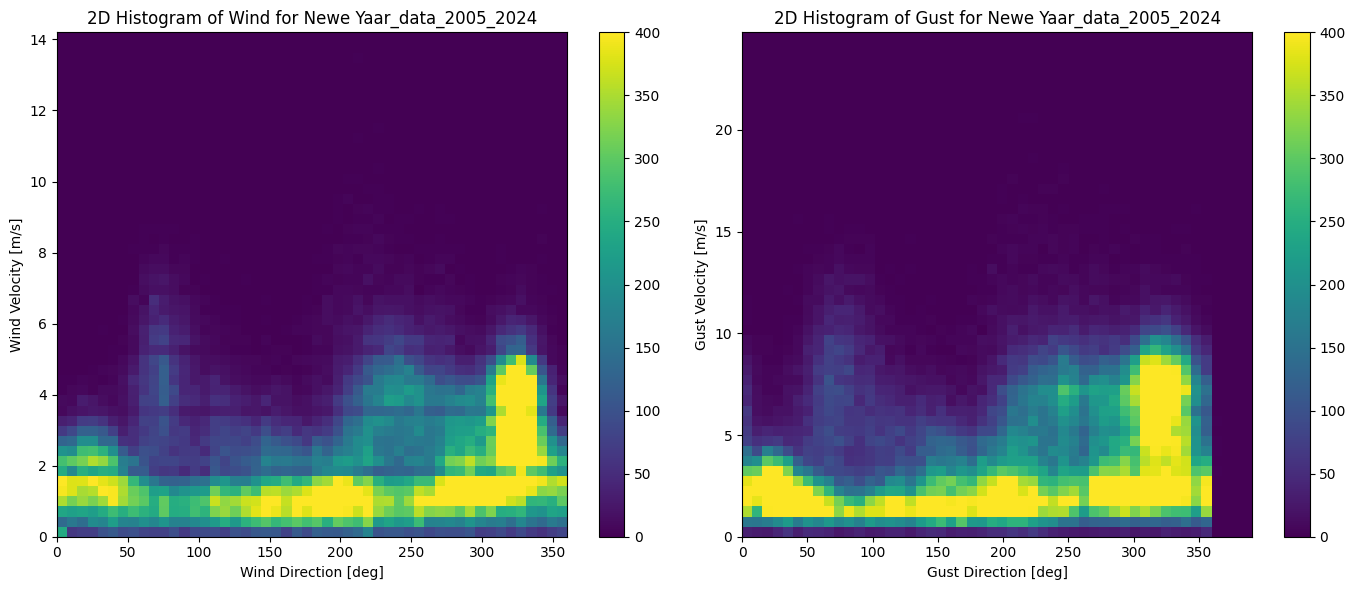

In [86]:
# Example: Plot 2D histogram plots of the wind: 'WD (deg)' and 'WS (m/s)' and gust: 'WDmax (deg)' and 'WSmax (m/s)' for the first dataframe

# Assuming 'dataframes' is a dictionary of DataFrames and we take the first one
first_df_name = list(dataframes.keys())[0]
first_df = dataframes[first_df_name]

# Replace specified na_values with np.nan
na_values = ['None', 'null', '-', '', ' ', 'NaN', 'nan', 'NAN']
first_df['WD (deg)'].replace(na_values, np.nan, inplace=True)
first_df['WS (m/s)'].replace(na_values, np.nan, inplace=True)
first_df['WDmax (deg)'].replace(na_values, np.nan, inplace=True)
first_df['WSmax (m/s)'].replace(na_values, np.nan, inplace=True)

# Convert columns to numeric, forcing errors to NaN
first_df['WD (deg)'] = pd.to_numeric(first_df['WD (deg)'], errors='coerce')
first_df['WS (m/s)'] = pd.to_numeric(first_df['WS (m/s)'], errors='coerce')
first_df['WDmax (deg)'] = pd.to_numeric(first_df['WDmax (deg)'], errors='coerce')
first_df['WSmax (m/s)'] = pd.to_numeric(first_df['WSmax (m/s)'], errors='coerce')

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Mask to filter out NaN values for wind
mask_wind = first_df['WD (deg)'].notna() & first_df['WS (m/s)'].notna()

# Create the 2D histogram plot for wind
hist_wind = ax[0].hist2d(first_df.loc[mask_wind, 'WD (deg)'], first_df.loc[mask_wind, 'WS (m/s)'], bins=(50, 50), vmax=400)
fig.colorbar(hist_wind[3], ax=ax[0])
ax[0].set_xlabel('Wind Direction [deg]')
ax[0].set_ylabel('Wind Velocity [m/s]')
ax[0].set_title(f'2D Histogram of Wind for {first_df_name}')

# Mask to filter out NaN values for gust
mask_gust = first_df['WDmax (deg)'].notna() & first_df['WSmax (m/s)'].notna()

# Create the 2D histogram plot for gust
hist_gust = ax[1].hist2d(first_df.loc[mask_gust, 'WDmax (deg)'], first_df.loc[mask_gust, 'WSmax (m/s)'], bins=(50, 50), vmax=400)
fig.colorbar(hist_gust[3], ax=ax[1])
ax[1].set_xlabel('Gust Direction [deg]')
ax[1].set_ylabel('Gust Velocity [m/s]')
ax[1].set_title(f'2D Histogram of Gust for {first_df_name}')

plt.tight_layout()
plt.show()

tranforming wind and gust into vectors:

In [87]:
for df_name, df in tqdm(dataframes.items(), desc="Processing DataFrames"):
    try:
        wind_speed = pd.to_numeric(df.pop('WS (m/s)'), errors='coerce')
        wind_direction_rad = pd.to_numeric(df.pop('WD (deg)'), errors='coerce') * np.pi / 180
        if wind_speed is not None and wind_direction_rad is not None:
            mask_wind = wind_speed.notna() & wind_direction_rad.notna()
            df['Wind_x'] = wind_speed * np.cos(wind_direction_rad)
            df['Wind_y'] = wind_speed * np.sin(wind_direction_rad)
            df.loc[~mask_wind, ['Wind_x', 'Wind_y']] = np.nan

        gust_speed = pd.to_numeric(df.pop('WSmax (m/s)'), errors='coerce')
        gust_direction_rad = pd.to_numeric(df.pop('WDmax (deg)'), errors='coerce') * np.pi / 180
        if gust_speed is not None and gust_direction_rad is not None:
            mask_gust = gust_speed.notna() & gust_direction_rad.notna()
            df['Gust_x'] = gust_speed * np.cos(gust_direction_rad)
            df['Gust_y'] = gust_speed * np.sin(gust_direction_rad)
            df.loc[~mask_gust, ['Gust_x', 'Gust_y']] = np.nan
    except KeyError as e:
        print(f"KeyError encountered in {df_name}: {e}")
    except TypeError as e:
        print(f"TypeError encountered in {df_name}: {e}")

Processing DataFrames:   0%|          | 0/3 [00:00<?, ?it/s]

Processing DataFrames: 100%|██████████| 3/3 [00:00<00:00,  8.04it/s]


ploting the wind and gust vectors after the transformation for the first station:

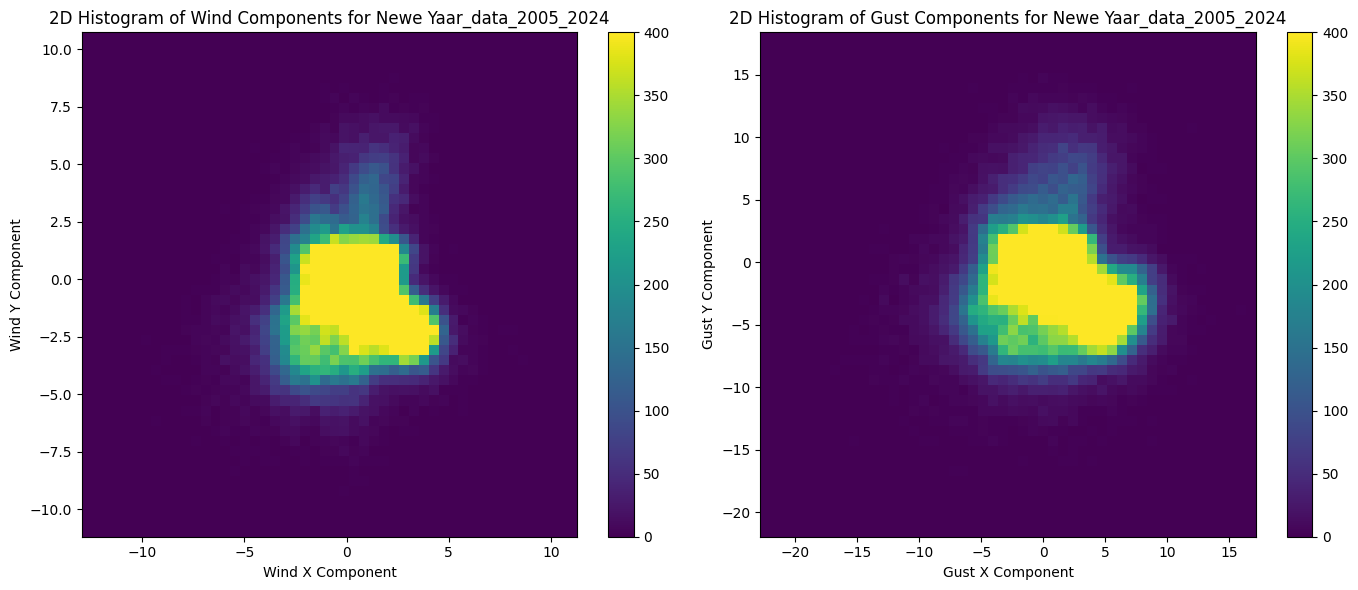

In [88]:
# Plot 2D histogram plots of the wind ('Wind_x', 'Wind_y') and gust ('Gust_x', 'Gust_y') for the first dataframe
first_df_name = list(dataframes.keys())[0]
first_df = dataframes[first_df_name]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Mask to filter out NaN values for wind
mask_wind = first_df['Wind_x'].notna() & first_df['Wind_y'].notna()

# Create the 2D histogram plot for wind
hist_wind = ax[0].hist2d(first_df.loc[mask_wind, 'Wind_x'], first_df.loc[mask_wind, 'Wind_y'], bins=(50, 50), vmax=400)
fig.colorbar(hist_wind[3], ax=ax[0])
ax[0].set_xlabel('Wind X Component')
ax[0].set_ylabel('Wind Y Component')
ax[0].set_title(f'2D Histogram of Wind Components for {first_df_name}')

# Mask to filter out NaN values for gust
mask_gust = first_df['Gust_x'].notna() & first_df['Gust_y'].notna()

# Create the 2D histogram plot for gust
hist_gust = ax[1].hist2d(first_df.loc[mask_gust, 'Gust_x'], first_df.loc[mask_gust, 'Gust_y'], bins=(50, 50), vmax=400)
fig.colorbar(hist_gust[3], ax=ax[1])
ax[1].set_xlabel('Gust X Component')
ax[1].set_ylabel('Gust Y Component')
ax[1].set_title(f'2D Histogram of Gust Components for {first_df_name}')

plt.tight_layout()
plt.show()

## print head

In [95]:
first_df_name = next(iter(dataframes))
print(f"Showing the head of the dataframe: {first_df_name}")
dataframes[first_df_name].head()

Showing the head of the dataframe: Newe Yaar_data_2005_2024


,Rain,RH (%),TD (degC),TDmax (degC),TDmin (degC),STDwd (deg),Date Time,Year,Wind_x,Wind_y,Gust_x,Gust_y
0,0.0,79.0,16.9,17.1,16.8,12.1,2005-04-01 00:00:00,2005,-1.050000,-1.818653,-2.069628,-3.186948
6,0.0,82.0,16.0,16.0,16.0,9.3,2005-04-01 01:00:00,2005,-1.484924,-1.484924,-1.763356,-2.427051
12,0.0,85.0,15.3,15.4,15.2,11.6,2005-04-01 02:00:00,2005,-1.807007,0.587132,-2.945616,1.250340
18,0.0,86.0,15.0,15.2,15.0,15.1,2005-04-01 03:00:00,2005,-1.199269,0.041879,-2.738813,-0.582153
24,0.0,88.0,14.8,14.8,14.8,18.6,2005-04-01 04:00:00,2005,-1.296833,-0.090683,-1.638304,-1.147153
